# 0.0 Imports

In [24]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import umap.umap_ as umap
import regex as re
import warnings

from IPython.display     import HTML
from matplotlib          import pyplot  as plt
from sklearn             import cluster as c
from sklearn             import metrics as m
from plotly              import express as px
from sklearn             import preprocessing as pp
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.1. Helper functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.set_option('display.expand_frame_repr', False)
    warnings.filterwarnings("ignore")    
    
    sns.set()
    
jupyter_settings()

## 0.2. Load dataset

In [6]:
# load data
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')

df_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,7-Dec-17,0.85,12680.0,France,NaN
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,7-Dec-17,2.10,12680.0,France,NaN
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,7-Dec-17,4.15,12680.0,France,NaN
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,7-Dec-17,4.15,12680.0,France,NaN


In [7]:
# drop extra column
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data description

In [103]:
df1 = df_raw.copy()

## 1.1 Rename columuns

In [9]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

## 1.2 Data types

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.3 Check NA

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.4 Replace NA

In [12]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format((1-(df1.shape[0] / df_raw.shape[0]))*100))

Removed data: 0.25%


In [13]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## 1.5 Change dtypes

In [14]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [15]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.6 Descriptive statistics

In [16]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.6.1 Numerical attributes

In [18]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
             
# dispersion - desvio padrão, minimo, maximo, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


#### 1.6.1.1 Quantity

In [37]:
print(len(df1[df1['quantity']==0]))
print(len(df1[df1['quantity']<0]))

0
8905


#### 1.6.1.2 Unit price

In [60]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.03)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,15838,United Kingdom
108088,C545478,D,Discount,-720,2017-03-01,0.010,16422,United Kingdom
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,13952,United Kingdom
182729,C552569,D,Discount,-240,2017-05-08,0.030,12901,United Kingdom
279045,561226,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-07-24,0.001,15618,United Kingdom
355050,C567903,M,Manual,-120,2017-09-20,0.030,16422,United Kingdom
359871,568200,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-09-23,0.001,16198,United Kingdom
361741,568375,BANK CHARGES,Bank Charges,1,2017-09-24,0.001,13405,United Kingdom


In [61]:
df1[(df1['unit_price']>0.00) & (df1['unit_price']<=0.04)]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2016-11-30,0.030,15838,United Kingdom
108088,C545478,D,Discount,-720,2017-03-01,0.010,16422,United Kingdom
157195,550193,PADS,PADS TO MATCH ALL CUSHIONS,1,2017-04-13,0.001,13952,United Kingdom
182729,C552569,D,Discount,-240,2017-05-08,0.030,12901,United Kingdom
217060,555876,16045,POPART WOODEN PENCILS ASST,100,2017-06-05,0.040,15799,United Kingdom
...,...,...,...,...,...,...,...,...
492556,578126,16045,POPART WOODEN PENCILS ASST,100,2017-11-21,0.040,16900,United Kingdom
506043,579124,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,15721,United Kingdom
506918,579161,16045,POPART WOODEN PENCILS ASST,100,2017-11-26,0.040,17379,United Kingdom
523461,580513,16045,POPART WOODEN PENCILS ASST,100,2017-12-02,0.040,14456,United Kingdom


In [50]:
len(df1[df1['unit_price']<0.05])

114

#### 1.6.1.3 Customer id

In [21]:
len(df1['customer_id'].unique())

4372

Negativate quantity - product return?

Unit price 0 - promotion/sale?

### 1.6.2 Categorical attributes

#### 1.6.2.1 Invoice no

In [32]:
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search( '[^0-9]+', x))),:]
# df_letter_invoices.head()

print('Total number of invoices with letters: {}'.format( len(df_letter_invoices)))
print('Total number of negative quantity: {}'.format(len(df_letter_invoices[ df_letter_invoices['quantity'] < 0 ])))
print('% of the total data: {:.2f}%'.format((df_letter_invoices.shape[0] / df1.shape[0])*100))

Total number of invoices with letters: 8905
Total number of negative quantity: 8905
% of the total data: 0.98%


#### 1.6.2.2 Stock code

In [39]:
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [41]:
df_stock_letters=df1.loc[df1['stock_code'].apply(lambda x: bool(re.search( '^[a-zA-Z]+$', x))), 'stock_code']
print('% of the total data: {:.2f}%'.format((df_stock_letters.shape[0] / df1.shape[0])*100))

% of the total data: 1.00%


#### 1.6.2.3 Description

In [42]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


#### 1.6.2.4 Country

In [43]:
df1['country'].value_counts( normalize=True ).head()

country
United Kingdom    0.889509
Germany           0.023339
France            0.020871
EIRE              0.018398
Spain             0.006226
Name: proportion, dtype: float64

In [62]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# 2.0 Variable filtering 

In [100]:
df2 = df1.copy()

In [101]:
# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map 
df2 = df2[~df2['country'].isin(['Unspecified'])]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]

# purchases
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

print('% of the data lost : {:.2f}%'.format(1-(df2.shape[0] / df1.shape[0])))

% of the data lost : 0.01%


# 3.0 Feature engineering 

In [120]:
df3 = df2.copy()

## 3.1 Feature creation

In [121]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates(ignore_index=True)


# Gross Revenue - quantity * price
df3['gross_revenue'] = df3['quantity'] * df3['unit_price']


# Monetary
df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')


# Recency - Last day of purchase
df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')


# Frequency
df_freq = df3[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


# Avg Ticket
df_avg_ticket = df3[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [122]:
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

# <font color='red'> 4.0 EDA (Exploratory Data Analysis) </font>

In [123]:
df4 = df_ref.copy()

# 5.0 Data preparation 

In [313]:
df5 = df4.copy()

In [275]:
## Robust Scalaer
ssgross = pp.MinMaxScaler()
ssrecency = pp.MinMaxScaler()
ssinvoice = pp.MinMaxScaler()
ssavg = pp.MinMaxScaler()

df5['gross_revenue'] = ssgross.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ssrecency.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ssinvoice.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ssavg.fit_transform(df5[['avg_ticket']])

In [301]:
## Robust Scalaer
ssgross = pp.StandardScaler()
ssrecency = pp.StandardScaler()
ssinvoice = pp.StandardScaler()
ssavg = pp.StandardScaler()

df5['gross_revenue'] = ssgross.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ssrecency.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ssinvoice.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ssavg.fit_transform(df5[['avg_ticket']])

# <font color='red'> 6.0 Feature selection </font>

In [314]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

In [315]:
X = df6.drop(columns=['customer_id'])

clusters = [2, 3, 4, 5, 6,7]

In [316]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,5288.63,302,35,16.950737
1,3089.10,46,16,15.923196
2,6629.34,2,17,28.209957
3,948.25,95,5,33.866071
4,635.10,330,6,105.850000


## 7.2 Elbow and silhouette score

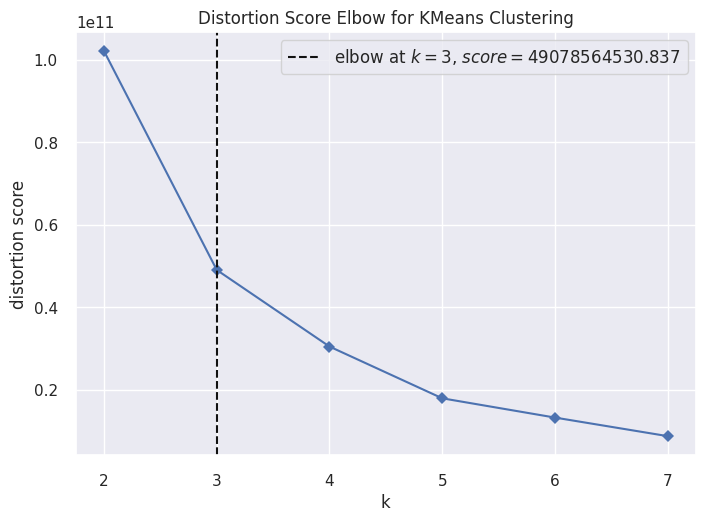

In [317]:
kmeans = KElbowVisualizer(c.KMeans(n_init='auto'),k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

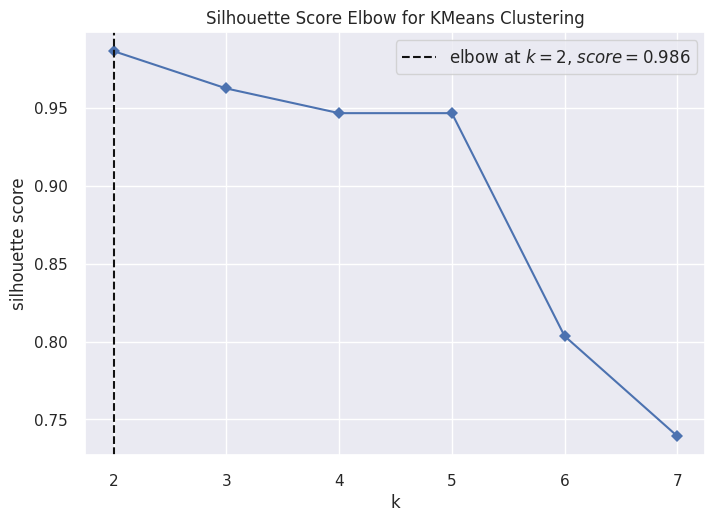

In [318]:
kmeans = KElbowVisualizer( c.KMeans(n_init='auto'), k=clusters, metric='silhouette', timings=False )
kmeans.fit( X )
kmeans.show();

## 7.2 Silhouette Analysis

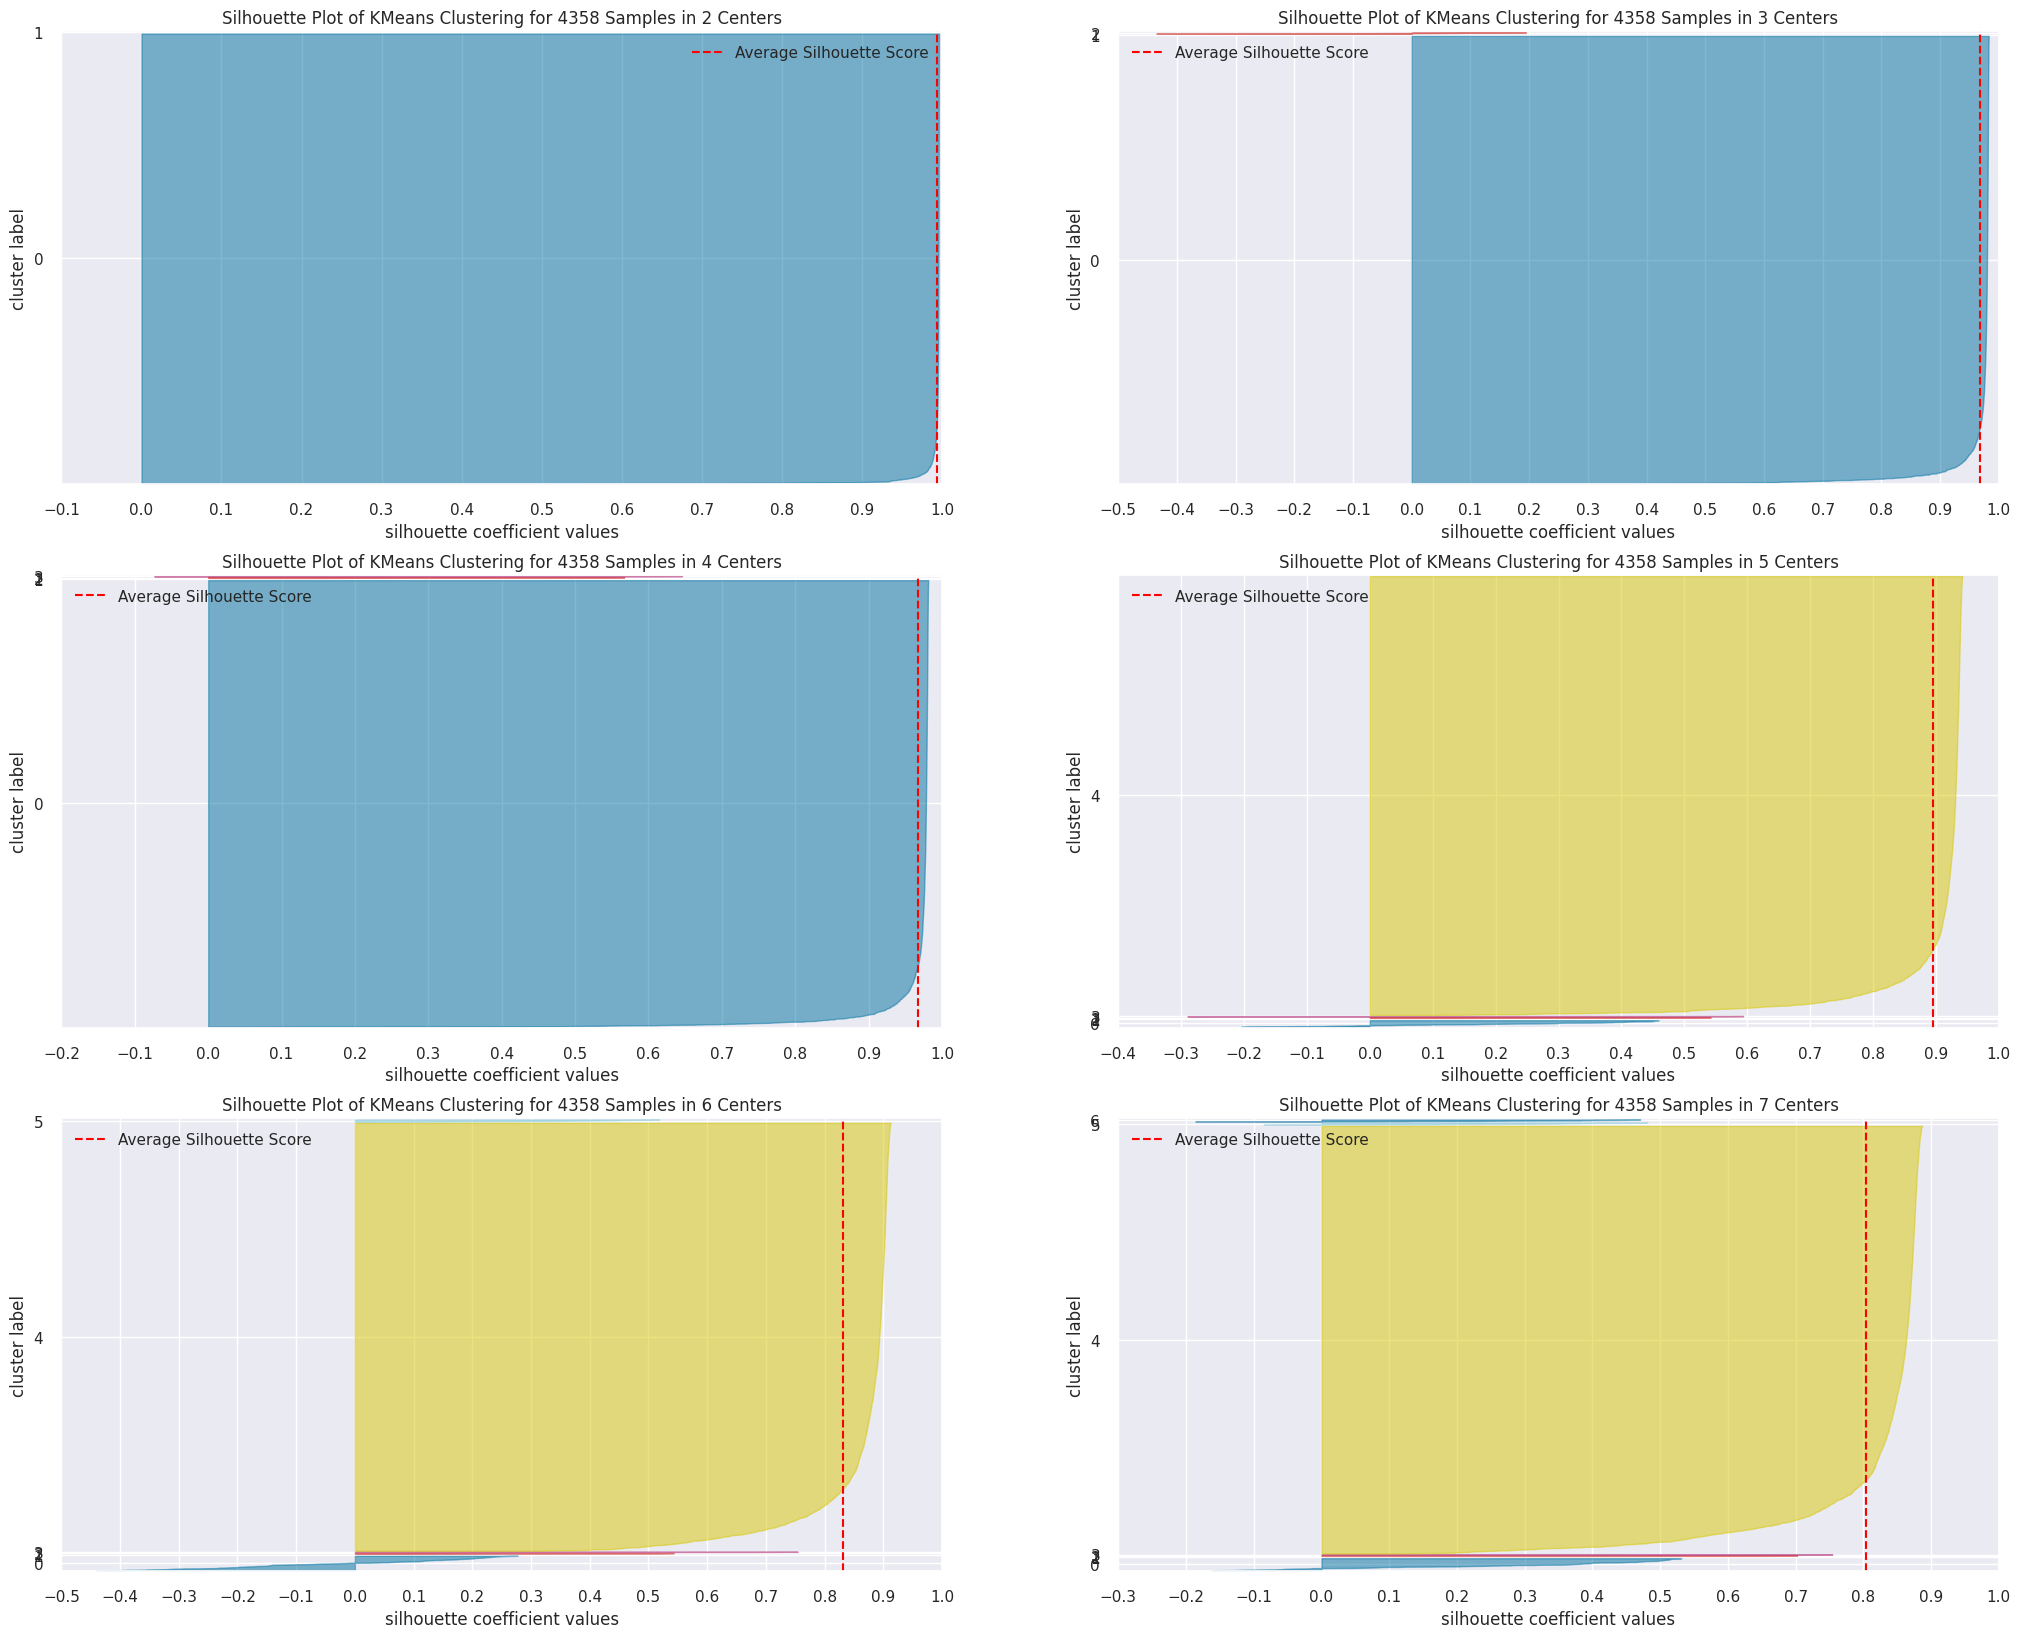

In [154]:
fig, ax = plt.subplots(3, 2, figsize=(25, 20))

for k in clusters:
    km = c.KMeans( n_clusters=k, n_init='auto',random_state=42)
    q, mod = divmod(k, 2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

#  8.0 Model training 

## 8.1 K-Means

In [319]:
# model definition
k = 3

kmeans = c.KMeans(n_clusters=k,random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster validation

In [320]:
## WSS (Within-cluster sum of square)
print('WSS value: {}'.format(kmeans.inertia_))

## SS (Silhouette Score 
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 49030556833.39172
SS value: 0.9624007896946248


# 9.0 Cluster analysis

In [321]:
df9 = df6.copy()
df9['cluster'] = labels

# df9['gross_revenue'] = ssgross.inverse_transform(df9[['gross_revenue']])
# df9['recency_days'] = ssrecency.inverse_transform(df9[['recency_days']])
# df9['invoice_no'] = ssinvoice.inverse_transform(df9[['invoice_no']])
# df9['avg_ticket'] = ssavg.inverse_transform(df9[['avg_ticket']])

## 9.1 Visualization inspection

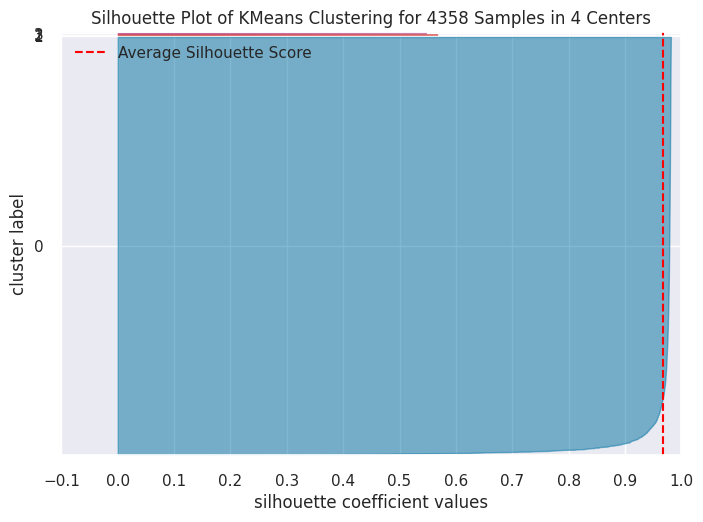

In [158]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2d plot

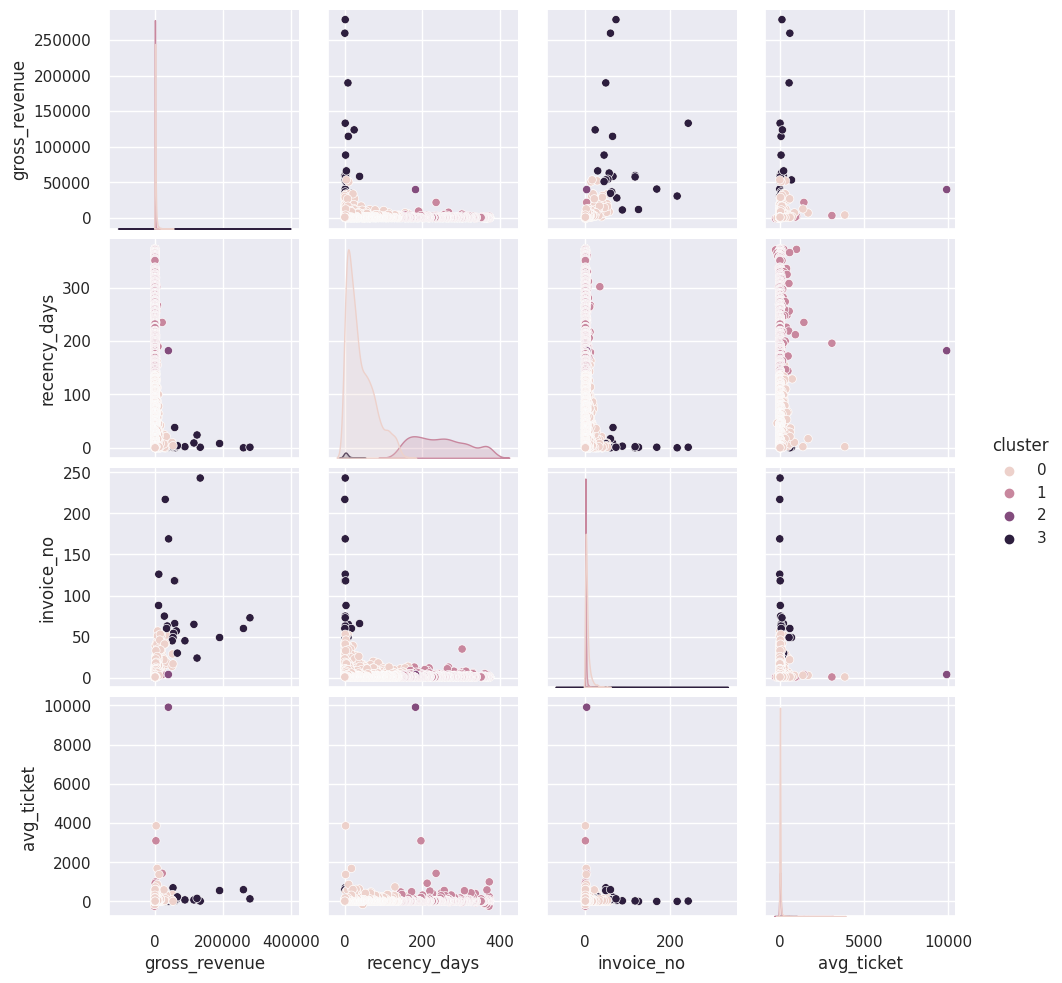

In [144]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster');

## 9.3 UMAP


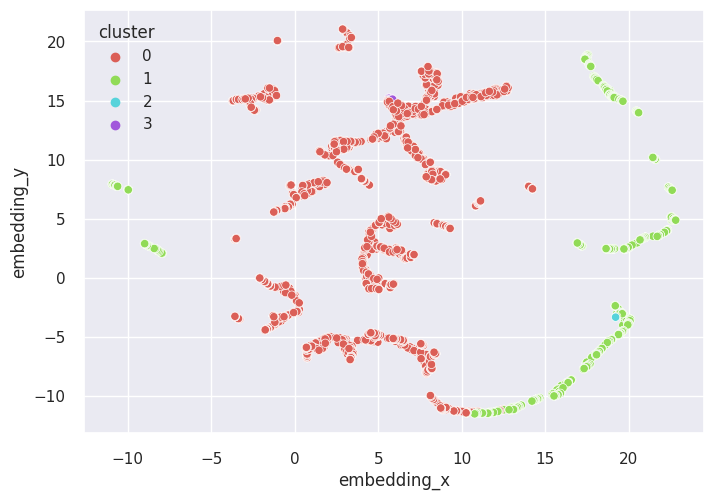

In [288]:
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
                 data=df_viz);

## 9.4 Cluster profile

In [322]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# Avg invoice_no
df_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Avg Ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster=df_cluster.sort_values(['gross_revenue'],ascending=False).reset_index(drop=True)
df_cluster.loc[0:0,'cluster'] = 0
df_cluster.loc[1:1,'cluster'] = 1
df_cluster.loc[2:2,'cluster'] = 2
df_cluster.loc[3:3,'cluster'] = 3

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,3,0.068839,242723.616667,3.000000,60.666667,431.898895
1,1,25,0.573658,56807.783600,14.040000,65.400000,536.685827
2,2,4330,99.357503,1418.640326,92.122633,4.612702,29.669198


In [234]:
print("Cluster 0 - Insider Candidate")
print(f"Number of customers: {df_cluster.iloc[0]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[0]['recency_days'].astype(int)}")
print(f"Purchases on average: {df_cluster.iloc[0]['invoice_no'].astype(int)}")
print(f"Average revenue: £{df_cluster.iloc[0]['gross_revenue']:,.2f}")

print('\n')

print("Cluster 1 ")
print(f"Number of customers: {df_cluster.iloc[1]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[1]['recency_days'].astype(int)}")
print(f"Purchases on average: {df_cluster.iloc[1]['invoice_no'].astype(int)}")
print(f"Average revenue: £{df_cluster.iloc[1]['gross_revenue']:,.2f}")

print('\n')

print("Cluster 2 ")
print(f"Number of customers: {df_cluster.iloc[2]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[2]['recency_days'].astype(int)}")
print(f"Purchases on average: {df_cluster.iloc[2]['invoice_no'].astype(int)}")
print(f"Average revenue: £{df_cluster.iloc[2]['gross_revenue']:,.2f}")

print('\n')

print("Cluster 3 ")
print(f"Number of customers: {df_cluster.iloc[3]['customer_id'].astype(int)}")
print(f"Average recency: {df_cluster.iloc[3]['recency_days'].astype(int)}")
print(f"Purchases on average: {df_cluster.iloc[3]['invoice_no'].astype(int)}")
print(f"Average revenue: £{df_cluster.iloc[3]['gross_revenue']:,.2f}")

Cluster 0 - Insider Candidate
Number of customers: 6
Average recency: 7
Purchases on average: 85
Average revenue: £183,220.25


Cluster 1 
Number of customers: 1
Average recency: 182
Purchases on average: 4
Average revenue: £39,619.50


Cluster 2 
Number of customers: 5
Average recency: 90
Purchases on average: 2
Average revenue: £9,527.08


Cluster 3 
Number of customers: 4346
Average recency: 91
Purchases on average: 4
Average revenue: £1,634.72


# <font color='red'> 10.0. Deploy To Production </font>